In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import os
import scipy.signal
from scipy.signal import butter, lfilter, savgol_filter, find_peaks
from scipy.optimize import curve_fit
from itertools import chain, zip_longest

In [31]:
class AnalysePSData:
    """ Input is noisy data from Pico-Scope. Output is (x, y) coordinate pairs of local maxima and minima. 
        Works by filtering the input signal, and then applying a standard max / min filter."""
    # fit spline to smooth signal
    
    def __init__(self, fp):
        self._ps_data = scipy.io.loadmat(fp)  # ps data as dictionary
        self.signal_raw = self._ps_data['A'][0] # A is photo-diode channel
        self.signal_sawtooth = self._ps_data['B'][0]  # B is drive channel on pico-scope
        self.signal_flp = np.array([0.]) # low-pass filter
        self.signal_savgol = np.array([0.]) # savitzky goyal filter
        self.signal_to_analyse = np.array([0.])  # signal that represents one sawtooth upwards turn
        self.signal_cos_fit = np.array([0.])
        self.f_cut_lp = 0 # low-pass cut frequency
        self.dT = self._ps_data['Tinterval'][0][0] # indices s.t. self.dT is an integer
        self.fs = 1 / self.dT # sampling rate in 1/s
        self.N = self.signal_raw.size
        self.t0 = self._ps_data['Tstart'][0][0]
        self.t1 = self.t0 + self.dT + self.N
        self.t = np.linspace(self.t0, self.t1, self.N)
        self.idx_wn = [np.argmin(self.signal_sawtooth), np.argmax(self.signal_sawtooth)] # indices that indicate start / end of sawtooth
        self.idx_loc_extr = np.array([0])
        self.idx_max, self.idx_min = np.array([0]), np.array([0])
        self.signal_sg_split = {}
        self.t_split, self.signal_raw_split = {}, {}
        assert self.t.size == self.signal_raw.size
        
    def get_sawtooth_local_extrema(self):
        """ Get local extrema of sawtooth function. Use min. height 0.95 percent of maximum value. Min. distance for N peaks should be
         larger than array.size // N """
        distance = self.signal_sawtooth.size // 10  # we expect five peaks
        height_min = np.amax(self.signal_sawtooth) * 0.95
        idx_max, _ = find_peaks(self.signal_sawtooth, distance=distance, height=height_min)
        signal_inv = np.amax(self.signal_sawtooth) - self.signal_sawtooth
        height_min = np.amax(signal_inv) * 0.95
        idx_min, _ = find_peaks(signal_inv, distance=distance, height=height_min)
        # interleave both lists - copied from Stack-Overflow
        if idx_max[0] < idx_min[0]: # max is first
            l1, l2 = idx_max, idx_min
        else:
            l1, l2 = idx_min, idx_max
        self.idx_loc_extr = np.array([x for x in chain(*zip_longest(l1, l2)) if x is not None], dtype=idx_max.dtype) 
        
    def fit_sinusoid(self, t1, w0=3.5e-3, phase0=0, verbose=False):
        """ Fits sinusoid w. frequency w0 to the first fringe of self.signal_to_analyse"""
        assert isinstance(self.signal_to_analyse, np.ndarray)
        def f(x, ac, dc, w, phase):
            return ac * np.sin(w * x + phase) + dc
        ydata = self.signal_to_analyse[:t1]
        xdata = np.arange(ydata.size)
        ac0 = (np.amax(self.signal_to_analyse) - np.amin(self.signal_to_analyse)) / 2
        dc0 = (np.amax(self.signal_to_analyse) + np.amin(self.signal_to_analyse)) * 0.5
        
        popt, _ = curve_fit(f, xdata, ydata, p0=[ac0, dc0, w0, phase0])
        if verbose:
            print(popt[-2:])
        t_all = np.arange(self.signal_to_analyse.size)
        self.signal_cos_fit = f(t_all, *popt)
        
    def filter_lowpass(self, cutoff_pc=0.01, order=6):
        """ Implement low-pass filter. cutoff_pc is the frequency (as percentage of sampling rate) at which signal is db3 attenuated.
            Partially copied."""
        self.f_cut_lp = cutoff_pc * self.fs  # desired cutoff frequency of the filter, Hz
        # Get the filter coefficients so we can check its frequency response.
        b, a = butter(order, self.f_cut_lp, fs=self.fs, btype='low', analog=False)
        self.signal_flp = lfilter(b, a, self.signal_raw)

    def filter_savgol(self, polyorder=2):
        """ apply savitzky golay filter"""
        window_length = self.N // 50
        self.signal_savgol = savgol_filter(self.signal_raw, window_length, polyorder)
        
    def split_signal_sg(self, buffer=0, flip=False):
        """ Splits sg-filtered signal into chunks marked by min. max. of sawtooth voltage."""
        if self.signal_sawtooth.size < 10:
            raise ValueError("Filter signal first")
        # If we have N max. and M min. we get N + M - 1 chunks
        num_chunks = self.idx_loc_extr.size - 1
        for i in range(num_chunks):  # not efficient but works for now
            sg = self.signal_savgol[self.idx_loc_extr[i]+buffer:self.idx_loc_extr[i + 1]-buffer]
            tt = self.t[self.idx_loc_extr[i]+buffer:self.idx_loc_extr[i + 1]-buffer]
            sr = self.signal_raw[self.idx_loc_extr[i]+buffer:self.idx_loc_extr[i + 1]-buffer]
            if flip and (i % 2 == 0): # flip every 2nd chunk
                sg = np.flip(sg)
                tt = np.flip(tt)
                sr = np.flip(sr)
            self.signal_sg_split[str(i)] = sg.tolist()
            self.t_split[str(i)] = tt.tolist()
            self.signal_raw_split[str(i)] = sr.tolist()
        
    def get_idx_local_extrema(self, rel_height=0.5, in_window=False, buffer=None):
        """ Uses Savitzky Golay filtered signal in window set by sawtooth function. Works only for one sawtooth upturn."""
        width = self.N // 100
        self.idx_max, _ = find_peaks(self.signal_savgol, width=width, wlen=None, rel_height=rel_height, plateau_size=None)
        signal_inv = np.amax(self.signal_savgol) - self.signal_savgol
        self.idx_min, _ = find_peaks(signal_inv, width=width, wlen=None, rel_height=rel_height, plateau_size=None)
        
        if in_window: # return only those indices i0 < i < i1
            assert buffer is not None
            imin, imax = self.idx_wn[0] + buffer, self.idx_wn[1] - buffer
            assert imax > imin, "Wrong ordering"
            mask_max = np.all([self.idx_max < imax, self.idx_max > imin], axis=0)
            self.idx_max = self.idx_max[mask_max]
            mask_min = np.all([self.idx_min < imax, self.idx_min > imin], axis=0)
            self.idx_min = self.idx_min[mask_min]
            
    def get_fringe_distances(self):
        """ verify that time indices are correct before visually"""
        diff_max = np.diff(self.idx_max, axis=0)
        diff_min = np.diff(self.idx_min, axis=0)
        
        return diff_max, diff_min
        

class PostProcess():
    """ Takes two filtered signals, calculates difference, and outputs length."""
    
    def __init__(self, signal_lbd1, signal_lbd2, lbd1, lbd2, tdata_lbd1, tdata_lbd2):
        self.lbd1 = lbd1
        self.lbd2 = lbd2
        self.tdata_lbd1, self.tdata_lbd2 = tdata_lbd1, tdata_lbd2
        self.signal_lbd1 = signal_lbd1
        self.signal_lbd2 = signal_lbd2
        self.idx_lbd1 = np.array([0])
        self.idx_lbd2 = np.array([0])
        self.T_lbd1, self.T_lbd2 = 0., 0.
        self.T, self.dT = 0., 0.
        self.use_lbd1 = None
        self.L = 0
        
    def get_local_extrema(self, buffer=None):
        """ local extrema indices for both wavelengths """
        distance = self.signal_lbd1.size // 6
        # local extrema indices for lbd-1
        height_min = np.amax(self.signal_lbd1) * 0.98
        
        idx_max_lbd1, _ = find_peaks(self.signal_lbd1, distance=distance, height=height_min)
        signal_inv = np.amax(self.signal_lbd1) - self.signal_lbd1
        height_min = np.amax(signal_inv) * 0.98
        idx_min_lbd1, _ = find_peaks(signal_inv, distance=distance, height=height_min)
            
        if idx_max_lbd1[0] < idx_min_lbd1[0]: # max is first
            l1, l2 = idx_max_lbd1, idx_min_lbd1
        else:
            l1, l2 = idx_min_lbd1, idx_max_lbd1
        self.idx_lbd1 = np.array([x for x in chain(*zip_longest(l1, l2)) if x is not None], dtype=np.int64)
        
        # for lbd-2
        height_min = np.amax(self.signal_lbd2) * 0.98
        idx_max_lbd2, _ = find_peaks(self.signal_lbd2, distance=distance, height=height_min)
        signal_inv = np.amax(self.signal_lbd2) - self.signal_lbd2
        height_min = np.amax(signal_inv) * 0.98
        idx_min_lbd2, _ = find_peaks(signal_inv, distance=distance, height=height_min)
        if idx_max_lbd2[0] < idx_min_lbd2[0]: # max is first
            l1, l2 = idx_max_lbd2, idx_min_lbd2
        else:
            l1, l2 = idx_min_lbd2, idx_max_lbd2
        self.idx_lbd2 = np.array([x for x in chain(*zip_longest(l1, l2)) if x is not None], dtype=np.int64)
        
        if buffer is not None: # prune outermost indices
            imin_lbd1, imax_lbd1 = 0 + buffer, self.signal_lbd1.size - buffer
            imin_lbd2, imax_lbd2 = 0 + buffer, self.signal_lbd2.size - buffer

            mask_lbd1 = np.all([self.idx_lbd1 < imax_lbd1, self.idx_lbd1 > imin_lbd1], axis=0)
            self.idx_lbd1 = self.idx_lbd1[mask_lbd1]
            mask_lbd2 = np.all([self.idx_lbd2 < imax_lbd2, self.idx_lbd2 > imin_lbd2], axis=0)
            self.idx_lbd2 = self.idx_lbd2[mask_lbd2]
            

    def calculate_T(self, from_left_to_right=True):
        if from_left_to_right:
            ii0, ii2 = 0, 2
            if self.idx_lbd1[ii0] > self.idx_lbd2[ii0]: # LBD2 is closer to edge
                print("Use LBD2 fringe. Edge index is ", ii0)
                self.use_lbd1 = False
            else:
                print("Use LBD1 fringe. Edge index ix ", ii0)
                self.use_lbd1 = True
        else:
            ii0, ii2 = -1, -3
            if self.idx_lbd1[ii0] > self.idx_lbd2[ii0]: # LBD1 is closer to edge
                print("Use LBD1 fringe. Edge index is ", ii0)
                self.use_lbd1 = True
            else:
                print("Use LBD2 fringe. Edge index ix ", ii0)
                self.use_lbd1 = False
        
        """ Calculate T, dT, and L """
        t_lbd1_extr = self.tdata_lbd1[self.idx_lbd1]
        t_lbd2_extr = self.tdata_lbd2[self.idx_lbd2]
        
        self.T_lbd1 = t_lbd1_extr[ii2] - t_lbd1_extr[ii0]
        self.T_lbd2 = t_lbd2_extr[ii2] - t_lbd2_extr[ii0]
        if self.use_lbd1:
            self.T = np.abs(self.T_lbd1)
            print("T0 and T1 for T: ", t_lbd1_extr[ii2], t_lbd1_extr[ii0])
        else:
            self.T = np.abs(self.T_lbd2)
            print("T0 and T1 for T: ", t_lbd2_extr[ii2], t_lbd2_extr[ii0])
        
        self.dT = np.abs(t_lbd1_extr[ii0] - t_lbd2_extr[ii0])
        print("T0 and T1 for dT: ", t_lbd1_extr[ii0], t_lbd2_extr[ii0])
        
    def calculate_L(self):
        lbd_diff = self.lbd2 - self.lbd1
        if self.use_lbd1:
            lbd = self.lbd1
        else:
            lbd = self.lbd2
        expr = 1/2 * self.dT/self.T * lbd**2 / lbd_diff
        self.L = expr*1e6 # um not nm

(10000.0, 70000.0)

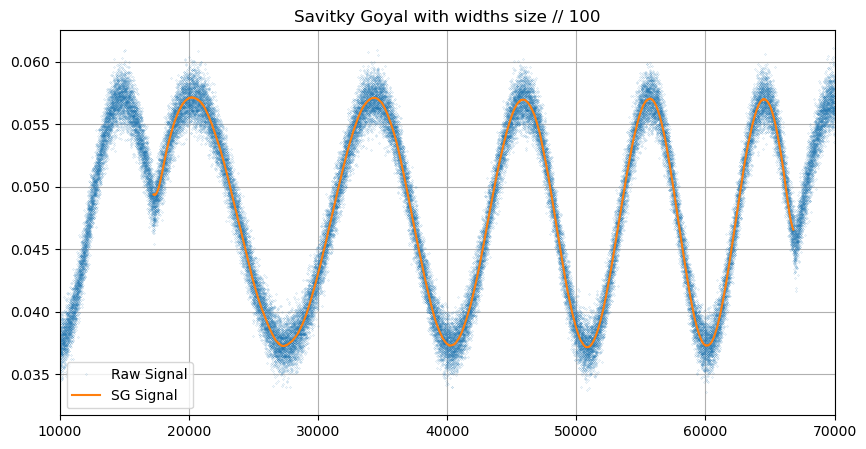

In [32]:
# Estimate non-linearity by fitting a cosine
dir_mmt = r"C:\Users\SLAB2\Documents\Waveforms\picoscope"
f_name = "281024_l=800um_wl=1534-529_x1sawtooth.mat"
fp = os.path.join(dir_mmt, f_name)

ps_data = AnalysePSData(fp)
ps_data.get_sawtooth_local_extrema()
ps_data.filter_savgol(polyorder=2)
ps_data.split_signal_sg(buffer=0, flip=False)

sg_split = ps_data.signal_sg_split["0"]
t_sg_split = ps_data.t_split["0"]

ps_data.signal_to_analyse = np.array(sg_split)
ps_data.fit_sinusoid(8000, w0=2e-4, phase0=0, verbose=False)

fig = plt.figure(figsize=(10, 5))

plt.plot(ps_data.t, ps_data.signal_raw, ".", label="Raw Signal", ms=0.2)
plt.plot(t_sg_split, sg_split, label="SG Signal")
# plt.plot(t_sg_split, ps_data.signal_cos_fit, label=f"Sine w. const. freq")
plt.legend()
plt.grid()
plt.title("Savitky Goyal with widths size // 100")
plt.xlim(10000, 70000)

Use LBD1 fringe. Edge index is  -1
T0 and T1 for T:  55707.541510481875 64580.630948022255
T0 and T1 for dT:  64580.630948022255 62738.612381104256
T is  8873.08943754038
dT is  1842.0185669179991
L is  936.4807226482812


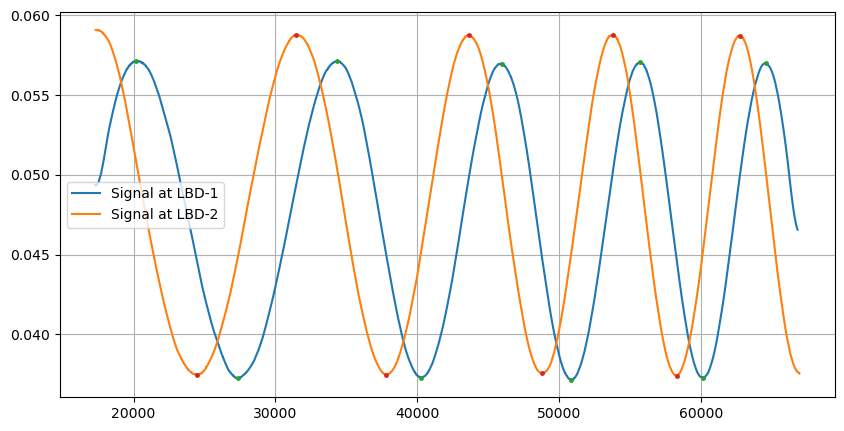

In [34]:
# Two wavelengths - visual confirmation
dir_mmt = r"C:\Users\SLAB2\Documents\Waveforms\picoscope"
f_name_lbd1 = "281024_l=800um_wl=1534-529_x1sawtooth.mat"
fp_lbd1 = os.path.join(dir_mmt, f_name_lbd1)
lbd1 = 1534.529e-9

ps_data_lbd1 = AnalysePSData(fp_lbd1)
ps_data_lbd1.get_sawtooth_local_extrema()
ps_data_lbd1.filter_savgol(polyorder=2)
ps_data_lbd1.split_signal_sg(buffer=0, flip=False)

signal_lbd1 = np.array(ps_data_lbd1.signal_sg_split["0"])
t_lbd_1 = np.array(ps_data_lbd1.t_split["0"])

f_name_lbd2 = "281024_l=800um_wl=1534-79_x1sawtooth.mat"
fp_lbd2 = os.path.join(dir_mmt, f_name_lbd2)
lbd2 = 1534.79e-9

ps_data_lbd2 = AnalysePSData(fp_lbd2)
ps_data_lbd2.get_sawtooth_local_extrema()
ps_data_lbd2.filter_savgol(polyorder=2)
ps_data_lbd2.split_signal_sg(buffer=0, flip=False)

signal_lbd2 = np.array(ps_data_lbd2.signal_sg_split["0"])
t_lbd_2 = np.array(ps_data_lbd2.t_split["0"])

data_combined = PostProcess(signal_lbd1, signal_lbd2, lbd1, lbd2, t_lbd_1, t_lbd_2)
data_combined.get_local_extrema(buffer=100)

fig = plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(data_combined.tdata_lbd1, data_combined.signal_lbd1, label="Signal at LBD-1")
plt.plot(data_combined.tdata_lbd2, data_combined.signal_lbd2, label="Signal at LBD-2")
plt.plot(data_combined.tdata_lbd1[data_combined.idx_lbd1], data_combined.signal_lbd1[data_combined.idx_lbd1], ".", ms=5.)
plt.plot(data_combined.tdata_lbd2[data_combined.idx_lbd2], data_combined.signal_lbd2[data_combined.idx_lbd2], ".", ms=5.)
plt.legend()

data_combined.calculate_T(from_left_to_right=False)
print("T is ", data_combined.T)
print("dT is ", data_combined.dT)
data_combined.calculate_L()
print("L is ", data_combined.L)

In [ ]:
# Two wavelengths

In [68]:
# # example
dir_mmt = r"C:\Users\SLAB2\Documents\Waveforms\picoscope"
f_name_lbd1 = "281024_l=800um_wl=1534-529_x1sawtooth.mat"
fp_lbd1 = os.path.join(dir_mmt, f_name_lbd1)
 
ps_data_lbd1 = AnalysePSData(fp_lbd1)
ps_data_lbd1.filter_lowpass(cutoff_pc=0.01, order=6)
ps_data_lbd1.filter_savgol(polyorder=2)
ps_data_lbd1.get_idx_local_extrema(rel_height=0.5, in_window=True, buffer=500)

f_name_lbd2 = "281024_l=800um_wl=1534-79_x1sawtooth.mat"
fp_lbd2 = os.path.join(dir_mmt, f_name_lbd2)
 
ps_data_lbd2 = AnalysePSData(fp_lbd2)
ps_data_lbd2.filter_lowpass(cutoff_pc=0.01, order=6)
ps_data_lbd2.filter_savgol(polyorder=2)
ps_data_lbd2.get_idx_local_extrema(rel_height=0.5, in_window=True, buffer=500)

[12152 10155  8962] [13370 10963  9521]


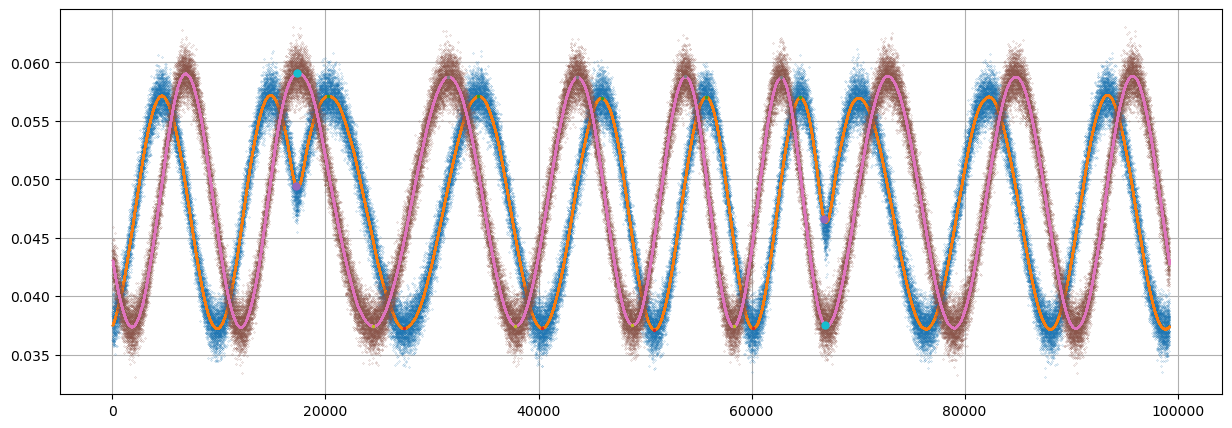

In [70]:
fig = plt.figure(figsize=(15, 5))

plt.plot(ps_data_lbd1.t, ps_data_lbd1.signal_raw, ".", ms=0.3)
plt.plot(ps_data_lbd1.t, ps_data_lbd1.signal_savgol, ".", ms=0.3)
plt.plot(ps_data_lbd1.t[ps_data_lbd1.idx_max], ps_data_lbd1.signal_savgol[ps_data_lbd1.idx_max], ".", ms=3.)
plt.plot(ps_data_lbd1.t[ps_data_lbd1.idx_min], ps_data_lbd1.signal_savgol[ps_data_lbd1.idx_min], ".", ms=3.)
plt.plot(ps_data_lbd1.t[ps_data_lbd1.idx_wn], ps_data_lbd1.signal_savgol[ps_data_lbd1.idx_wn], ".", ms=10.)

plt.plot(ps_data_lbd2.t, ps_data_lbd2.signal_raw, ".", ms=0.3)
plt.plot(ps_data_lbd2.t, ps_data_lbd2.signal_savgol, ".", ms=0.3)
plt.plot(ps_data_lbd2.t[ps_data_lbd2.idx_max], ps_data_lbd2.signal_savgol[ps_data_lbd2.idx_max], ".", ms=3.)
plt.plot(ps_data_lbd2.t[ps_data_lbd2.idx_min], ps_data_lbd2.signal_savgol[ps_data_lbd2.idx_min], ".", ms=3.)
plt.plot(ps_data_lbd2.t[ps_data_lbd2.idx_wn], ps_data_lbd2.signal_savgol[ps_data_lbd2.idx_wn], ".", ms=10.)
plt.grid()

In [77]:
# compare dT's
# one thing we could do is to compare length of lbd-1 and lbd-2
idx_unshifted_max = np.flip(ps_data_lbd1.idx_max)[:-1]  # last one is shifted away
idx_unshifted_min = np.flip(ps_data_lbd1.idx_min) 

idx_shifted_max = np.flip(ps_data_lbd2.idx_max)
idx_shifted_min = np.flip(ps_data_lbd2.idx_min)

dT_max = idx_unshifted_max - idx_shifted_max
dT_min = idx_unshifted_min - idx_shifted_min

print(dT_max, dT_min)

print(dT_max[0] / dT_max[1], dT_min[0] / dT_min[1])

[1842 1931 2316 2864] [1831 2054 2471 2921]
0.953909891248058 0.8914313534566699


In [83]:
# compare fringes 
fringes_unshifted_max = np.diff(ps_data_lbd1.idx_max, axis=0)
fringes_unshifted_min = np.diff(ps_data_lbd1.idx_min, axis=0)

fringes_shifted_max = np.diff(ps_data_lbd2.idx_max, axis=0)
fringes_shifted_min = np.diff(ps_data_lbd2.idx_min, axis=0)

print(fringes_shifted_max, fringes_unshifted_max)
print(fringes_shifted_min, fringes_unshifted_min)

print(fringes_shifted_max[-1] / fringes_unshifted_max[-1])
print(fringes_shifted_min[-1] / fringes_unshifted_min[-1])

print(fringes_unshifted_max[-1] / fringes_unshifted_max[-2])

[12152 10155  8962] [14124 11604  9770  8873]
[13370 10963  9521] [12920 10546  9298]
1.010030429392539
1.0239836523983652
0.908188331627431


[ 2067 10334 18602 26869 35136 43404]
[  -43   563  2065  5402 11259]
-43
1.073303495826781


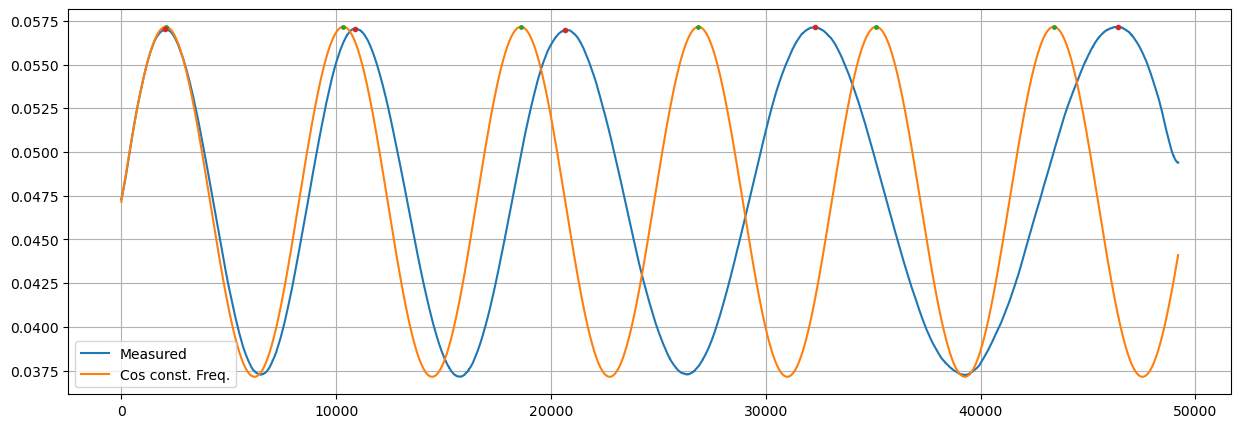

In [245]:
# Do a curve fit
from scipy.optimize import curve_fit

fig = plt.figure(figsize=(15, 5))

i0, i1 = ps_data_lbd1.idx_wn[0], ps_data_lbd1.idx_wn[1]
to_fit = np.flip(ps_data_lbd1.signal_savgol[i0+200: i1-200])
xdata = np.arange(to_fit.size)

plt.plot(xdata, to_fit, label="Measured")
plt.grid()

def f(x, a, b, c, phase, ac, dc):
    poly = - a*x**2 - b*x + c  # 3rd order polynomial
    return ac * np.cos(poly * x + phase) + dc

phase0 = 3*np.pi/2 # graph starts at 0
ac0 = (np.amax(to_fit) - np.amin(to_fit)) / 2
dc0 = (np.amax(to_fit) + np.amin(to_fit)) * 0.5
a0, b0, c0 = 1, 1.e-9, 7.6e-4

p0 = [a0, b0, c0, phase0, ac0, dc0]

popt, pcov = curve_fit(f, xdata, to_fit, p0=p0)

ww = xdata.size // 50
idx_max_meas, _ = find_peaks(to_fit, width=ww)

out_const = f(xdata, 0, 0, c0, phase0, ac0, dc0)
out_lin = f(xdata, 0, b0, c0, phase0, ac0, dc0)
out_square = f(xdata, 4e-12, b0, c0, phase0, ac0, dc0)


idx_max_const, _ = find_peaks(out_const, width=ww)

print(idx_max_const)

# out = f(xdata, *popt)
plt.plot(xdata, out_const, label="Cos const. Freq.")
plt.plot(xdata[idx_max_const], out_const[idx_max_const], ".", ms=5)
plt.plot(xdata[idx_max_meas], to_fit[idx_max_meas], ".")
# plt.plot(xdata, out_lin, label="Lin. Freq.")
# plt.plot(xdata, out_square, label="Square. Freq.")
plt.legend()

print(idx_max_meas - idx_max_const[:-1])

nonlinearity = idx_max_meas - idx_max_const[:-1]

print(nonlinearity[0])

print((idx_max_meas[1] - idx_max_meas[0]) / (idx_max_const[1] - idx_max_const[0]))


Text(0, 0.5, 'Nonlinearity in %')

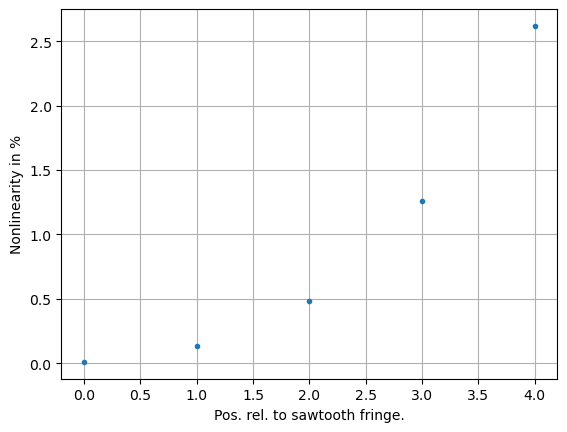

In [251]:
plt.plot(np.abs(nonlinearity / nonlinearity[0]) / 100, ".")
plt.grid()
plt.xlabel("Pos. rel. to sawtooth fringe.")
plt.ylabel("Nonlinearity in %")
# plt.yticks(np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 1., 1.5, 2., 2.5]))